In [10]:
from __future__ import print_function, division
from builtins import range, input

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

# load in the data
df = pd.read_csv('very_small_rating.csv')

In [59]:
df.sample(5)

,userId,movieId,rating,movie_idx
59189,1325,2571,3.0,8
132628,4191,316,0.5,55
520783,2545,296,4.0,0
438669,2016,1291,4.0,58
221328,3339,47,3.5,23


In [12]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies
print("Total No. of Users: ",N," Total No. of Movies: ",M)

Total No. of Users:  5000  Total No. of Movies:  150


In [15]:
#Shuffle the dataframe
df=shuffle(df)
print(df.shape)

(560669, 4)


In [16]:
# split into train and test
cutoff = int(0.8*len(df))
print(cutoff)
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]
print(df_train.shape,df_test.shape)

448535
(448535, 4) (112134, 4)


In [17]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
reg = 0. # regularization penalty

In [18]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u) # (N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m) # (N, 1, K)

W0517 16:32:02.000485 4561110464 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
#Build the bias term
u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u) # (N, 1, 1)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m) # (N, 1, 1)
#Matrix of the embeddings
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)

In [21]:
#Add the bias embeddings to the matrix
x = Add()([x, u_bias, m_bias])
#Flatten the entire matrix
x = Flatten()(x) # (N, 1)

In [22]:
#Inputs and output of the model
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

In [23]:
r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movie_idx.values],
    df_test.rating.values - mu
  )
)

W0517 16:36:20.042325 4561110464 module_wrapper.py:139] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 448535 samples, validate on 112134 samples
Epoch 1/15
448535/448535 [==============================] - 7s 15us/step - loss: 0.7178 - mse: 0.7178 - val_loss: 0.6675 - val_mse: 0.6675
Epoch 2/15
448535/448535 [==============================] - 6s 14us/step - loss: 0.6562 - mse: 0.6562 - val_loss: 0.6523 - val_mse: 0.6523
Epoch 3/15
448535/448535 [==============================] - 6s 14us/step - loss: 0.6415 - mse: 0.6415 - val_loss: 0.6344 - val_mse: 0.6344
Epoch 4/15
448535/448535 [==============================] - 6s 14us/step - loss: 0.6039 - mse: 0.6039 - val_loss: 0.6002 - val_mse: 0.6002
Epoch 5/15
448535/448535 [==============================] - 6s 14us/step - loss: 0.5679 - mse: 0.5679 - val_loss: 0.5763 - val_mse: 0.5763
Epoch 6/15
448535/448535 [==============================] - 6s 14us/step - loss: 0.5255 - mse: 0.5255 - val_loss: 0.5558 - val_mse: 0.5558
Epoch 7/15
448535/448535 [==============================] - 6s 13us/step - loss: 0.4924 - mse: 0.4924 - val_loss: 

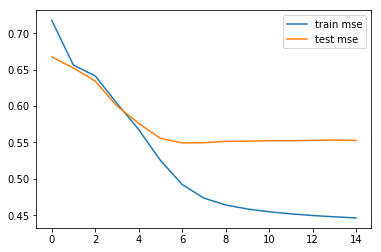

In [29]:
# plot mse
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()

In [45]:
#Prediction
user_ids = df_test.userId.values[0:5]
movie_ids = df_test.movie_idx.values[0:5]
new_mu=df_test.rating.values[0:5].mean()
test_ratings=df_test.rating.values[0:5]
pred=model.predict([user_ids,movie_ids])

In [50]:
print(pred," ",(test_ratings-new_mu))

[[-0.31776702]
 [-1.7063041 ]
 [ 0.4101449 ]
 [ 0.9201714 ]
 [ 0.21042894]]   [-0.4 -1.9  0.1  1.1  1.1]


In [61]:
#User 980 would rate the movie 47 as below
model.predict([np.array([980]),np.array([47])]) + mu

array([[2.8034449]], dtype=float32)

In [40]:
#Mse the lower the better
print(r.history['mse'][len(r.history['mse'])-1],r.history['val_mse'][len(r.history['val_mse'])-1])

0.44644615 0.5527645945549011
